# Preliminaries

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  8 22:29:59 2021

@author: ptbowen
"""
import sys
sys.path.append('..')
import worx.ElectromagneticObjects as emag
import worx.MathObjects as math
import worx.PlotTools as PlotTools
import worx.Geometries as geom

import numpy as np
from numpy.lib.scimath import sqrt
from mayavi import mlab

pi=np.pi
c=2.998e8
(xhat,yhat,zhat)=math.CreateEuclideanBasis()
vec_space=[xhat,yhat,zhat]

# Setup

In this notebook we will actually use a modulator to implement beamforming on a single waveguide.  First we are going to define some quantities that the modulator is going to need, like the desired beam angle and polarization vector.  The modulator needs a vector to represesnt the beam angle (the k-vector of the beam) and a vector to specify the polarization of the electric field.  Here we use the spherical basis vectors as a conventient way to define them as a function of the beam angle.

While we are at it, we will also go ahead and define our waveguide and half-space.

In [2]:
# Operating frequency and beam definition
f0=10.2e9
lmbda=c/f0
k=2*pi/lmbda
theta_b=90*pi/180
phi_b=30*pi/180
k_b=math.SphericalBasis('r')(theta_b,phi_b)*k
E_b=math.SphericalBasis('phi')(theta_b,phi_b)

# Waveguide design
n_wg=sqrt(3.55*(1-0.0027j))
pitch=0.006
N=30
L=N*pitch
a=14e-3
b=0.762e-3
WG=geom.Waveguide(a,b,n_wg,L)
WG.N_modes=1
# WG.N_modes=10

# Create a half space for far-field calcs
HS=geom.HalfSpace()

Next we create an initial dipole, extract the polarizability and plot it over both frequency and modulation parameter so we can see our tuning range.

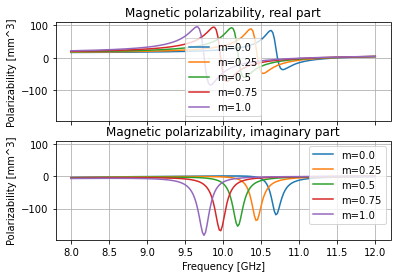

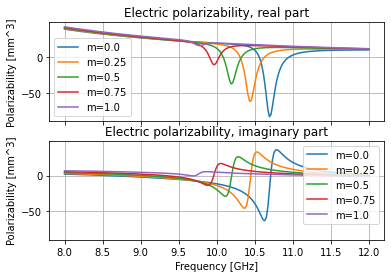

In [3]:
# Data files for polarizability extraction
S11MagFile='../HFSS/S11mag_MikeCell_CapSweep.csv'
S11PhaseFile='../HFSS/S11phase_MikeCell_CapSweep.csv'
S21MagFile='../HFSS/S21mag_MikeCell_CapSweep.csv'
S21PhaseFile='../HFSS/S21phase_MikeCell_CapSweep.csv'
HFSS_Files={'S11Mag':S11MagFile,'S11Phase':S11PhaseFile,
            'S21Mag':S21MagFile,'S21Phase':S21PhaseFile}

r0=xhat*1.6e-3
dip=emag.Dipole(r0)
dip.extract(WG,HFSS_Files,parameterized=1)
f=np.linspace(8e9,12e9,200)
mod_range=np.linspace(0,1,5)
dip.analyze(f=f,mod=mod_range)

Now we will duplicate this tunable dipole into an array and assign the dipoles in the array to the waveguide, and plot the geometry to confirm that it's what we wanted.

In [4]:
# Dipole array design
z_pos=np.arange(pitch/2,(N+1/2)*pitch,pitch)+1.2e-3
x_pos=np.ones(np.shape(z_pos))*dip.r0[xhat]
y_pos=np.ones(np.shape(z_pos))*dip.r0[yhat]
r_pos=math.GridToListOfVectors({xhat:x_pos,yhat:y_pos,zhat:z_pos})
dip_array=dip.Array(r_pos)
for dipole in dip_array:
    WG.add_dipole(dipole)
    HS.add_dipole(dipole)
    
# Now, position it where you want it in space
R=math.RotTensor(pi/2,'x',vec_space)
WG.Rotate(R)

# Plot geometry
mlab.init_notebook()
mlab.clf(1)
WG.MayaviPlot(1,plot_fields=False,field_clip=30,phase=1.08*pi)
PlotTools.MayaviAxes(10,-L/3,L/3,0,L,-L/10,L/2)
mlab.figure(figure=1,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

Now we define a source, modulate, and solve initially using the unperturbed feed wave approximation (we will do fully coupled later).  Let's initially get a sanity check by plotting the near-fields so we can see the unperturbed propagation of the feed wave down the waveguide.  The modulator will also create a polar plot of the ideal polarizabilities, achievable polarizabilities, and arrows indicating the mapping between ideal and realized polarizabilities.

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

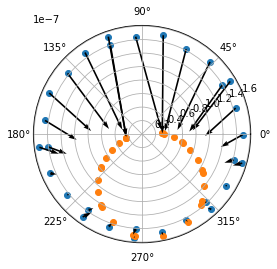

In [5]:
# Define source (You have to do this before you can modulate)
WG.Source(f0)

# Modulate
WG.Modulate(k_b,E_b,plot=1)

# Compute
WG.Compute(f0,compute_type='unperturbed')
HS.ComputeFarField(f0)

# Plot geometry
mlab.init_notebook()
mlab.clf(2)
WG.MayaviPlot(1,plot_fields=True,field_clip=30,phase=1.08*pi)
PlotTools.MayaviAxes(10,-L/3,L/3,0,L,-L/10,L/2)
mlab.figure(figure=2,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))

Now we can plot the resulting far-field.  It should give a nice fan beam.

In [6]:
# Far field plotting
directivity=HS.FarField.directivity
k=HS.FarField.k
(theta_grid,phi_grid,th_axis,ph_axis,dth,dph)=math.HalfSphereGrid(360,90)
Dir_dB=10*np.log10(np.real(directivity(k(theta_grid,phi_grid)))+1e-16) 
Dir_dB[Dir_dB<0]=0
rhat=math.SphericalBasis('r')
X=Dir_dB*(rhat.dot(xhat))(theta_grid,phi_grid)
Y=Dir_dB*(rhat.dot(yhat))(theta_grid,phi_grid)
Z=Dir_dB*(rhat.dot(zhat))(theta_grid,phi_grid)

mlab.init_notebook()
mlab.clf(3)
mlab.mesh(X,Y,Z)
coordmax=np.max([X,Y,Z])
PlotTools.MayaviAxes(10,-coordmax,coordmax,-coordmax,coordmax,0,coordmax)
mlab.figure(figure=3,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

Now let's solve with the fully coupled solver, and you will see the decay of the feed wave.

In [7]:
# Compute
WG.Compute(f0,compute_type='coupled')
HS.ComputeFarField(f0)

# Plot geometry and near fields
mlab.init_notebook()
mlab.clf(4)
WG.MayaviPlot(1,plot_fields=True,field_clip=30,phase=1.08*pi)
PlotTools.MayaviAxes(10,-L/3,L/3,0,L,-L/10,L/2)
mlab.figure(figure=4,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

The resulting far-field has bigger side lobes and a significantly fatter and shorter main beam.

In [9]:
# Far field plotting
directivity=HS.FarField.directivity
k=HS.FarField.k
(theta_grid,phi_grid,th_axis,ph_axis,dth,dph)=math.HalfSphereGrid(360,90)
Dir_dB=10*np.log10(np.real(directivity(k(theta_grid,phi_grid)))+1e-16) 
Dir_dB[Dir_dB<0]=0
rhat=math.SphericalBasis('r')
X=Dir_dB*(rhat.dot(xhat))(theta_grid,phi_grid)
Y=Dir_dB*(rhat.dot(yhat))(theta_grid,phi_grid)
Z=Dir_dB*(rhat.dot(zhat))(theta_grid,phi_grid)

mlab.init_notebook()
mlab.clf(5)
mlab.mesh(X,Y,Z)
coordmax=np.max([X,Y,Z])
PlotTools.MayaviAxes(10,-coordmax,coordmax,-coordmax,coordmax,0,coordmax)
mlab.figure(figure=5,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…